# Setup

Follow [this tutorial](https://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/) for setting up the problem.

The following code chunks is essential for setting up keras backend, as well as adopting some of it's attributes including models, layers, optimizers, etc. Additionally, we set a random seed to ensure the results we get are reproducable, and make a connection to the dataset "CIFAR-10", which is included in the keras library. The second code chunk is responsible for limiting our tensorflow GPU usage on the UWL volta machine (which we ssh into), where the computation limit is initially small, then allowed to grow up to 5% of the machines' capability.

In [1]:
# model dependencies
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend
import tensorflow
seed = 7 # make sure results are reproducable
tensorflow.set_random_seed(seed)
import numpy
numpy.random.seed(seed)
#K.set_image_dim_ordering('th')

# CIFAR data dependencies
from keras.datasets import cifar10

# plotting images
from matplotlib import pyplot
from scipy.misc import toimage

Using TensorFlow backend.


In [2]:
########################
# Limit TensorFlow GPU use.
config = tensorflow.ConfigProto()
config.gpu_options.allow_growth = True # start at a small fraction of GPU, but use more if necessary
config.gpu_options.per_process_gpu_memory_fraction = 0.05 # MAX GPU = 5%
backend.tensorflow_backend.set_session(tensorflow.Session(config=config))
########################

# Data Introduction

The CIFAR-10 dataset consists of 60,000 32x32 pixel RGB colored images. The photos are divided into 10 classes, which include common objects such as airplanes, automobiles, birds, cats and so on. We utilize 50,000 images to train a model, and set aside the other 10,000 for testing. We also have output labels of a single dimension to tell us which class the image belongs to. The second code chunk below is simply a useful method for printing a 3x3 grid of images from the dataset.

In [3]:
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data() # pickled data
print 'Train set:', [X_train.shape, y_train.shape]
print 'Test set :', [X_test.shape, y_test.shape]

Train set: [(50000, 32, 32, 3), (50000, 1)]
Test set : [(10000, 32, 32, 3), (10000, 1)]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  after removing the cwd from sys.path.


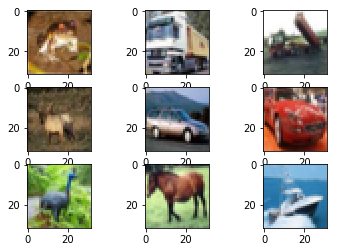

In [4]:
# create a grid of 3x3 images
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(toimage(X_train[i]))
# show the plot
pyplot.show()

### Preprocessing

Pixel values are initally stored as integers in the range of 0 (white) to 255 (black); we must "normalize" these values by converting them to floating-point values and then dividing by 255 (obviously...) to get them in the range of 0.0-1.0, to help convergence in our model. Output values are initially stored as a vector of integers for each class. Because we are dealing with a classification problem, we can utilize one-hot encoding to transform the outputs into a binary matrix, such that we end up with a 10-unit output vector.

In [4]:
# normalize inputs
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# one hot encode outputs
y_train = np_utils.to_categorical(y_train) # format: (1,0)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1] # number of "columns" in y (should be 2 for binary)

print 'X_train shape:', X_train.shape[1:]
print 'y_train shape:', y_train.shape[1]
print X_train.shape[0], 'train samples'
print X_test.shape[0], 'test samples'

X_train shape: (32, 32, 3)
y_train shape: 10
50000 train samples
10000 test samples


# Build Initial Model

The initial structure consists of 2 convolutional layers followed by max pooling and a flattening out of the network to fully connected layers to make predictions.

Important pieces to note in the network architecture include the functionality of each layer. We create a new model with the *Sequential()* call, then add a convolutional layer (essentially a 3x3 filter or "flashlight" passing over the image) with relu activation and "0" padding around the perimeter of the image to ensure we retain the same output size (i.e., it's okay to run off the edge of the image, we just don't worry about including those pieces in our future layers).

The second layer is a "dropout" layer, where we specify a fraction (20% in this case) of the neurons in that layer to be randomly dropped from training, which pushes their functionality off to another neuron in that layer. This is beneficial for training much deeper neural networks, and to ensure that each neuron isn't learning a specific function "too well".

We also include a 2x2 max pooling layer, which is essentially going to shrink the dimensionality at that layer and allow assumptions to be made about the features in that window.

*Flatten* layer will take the output of the previous layer, and unroll it into a long 1-D vector of values to be fed into a fully connected (F.C.) layer. An F.C. layer of 512 units is included after this, and will have neurons connected to each neuron in the previous layer (as was the scope of building our feed-forward NN).

Finally, we add another dropout layer and our classification layer with a 10-unit F.C. softmax output, corresponding to our 10-dimensional output vector of binary probabilities. Although this output will not necessarily be 0/1's, it will be a vector of probabilities that will (ideally) converge to values close to 0 or 1, depending on the correct output and values calculated from the weights calculated in the model.

Baseline network structure:
    1. Conv input with 32 feature maps with size 3x3, relu activation, and weight constraint of max norm 3.
    2. Dropout 20%
    3. Conv layer with 32 feature maps with size 3x3, relu activation, and weight constraint of max norm 3.
    4. Max pool of size 2x2
    5. Flatten
    6. Dense (F.C.) layer with 512 units and relu activation
    7. Dropout 50%
    8. 10-unit F.C. softmax output layer

We initially train the model with specified learning rate of 0.01 and stochastic gradient descent. A logarithmic loss function (similar to that of binary cross entropy, but for multi-class) is utilized for computing error.

Setting batch size to 32, we are saying that the model should train on 32 images for each forward/backward pass. Benefits of having a smaller batch size include decreased run-time and less memory. However, small batches are also less acurate in estimating the gradient.

In our first pass, we also set epoch to 25, indicating that we will make 25 iterations over *all* examples in the dataset. So, if we have a batch size of 32, it will take $50000/32 = 1562$ iterations to complete 1 epoch.

In [5]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [6]:
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 22s 442us/step - loss: 1.7116 - acc: 0.3779 - val_loss: 1.3495 - val_acc: 0.5178
Epoch 2/25
50000/50000 [==============================] - 20s 405us/step - loss: 1.3224 - acc: 0.5212 - val_loss: 1.1828 - val_acc: 0.5809
Epoch 3/25
50000/50000 [==============================] - 20s 394us/step - loss: 1.1610 - acc: 0.5830 - val_loss: 1.0938 - val_acc: 0.6071
Epoch 4/25
50000/50000 [==============================] - 19s 382us/step - loss: 1.0436 - acc: 0.6285 - val_loss: 1.0308 - val_acc: 0.6335
Epoch 5/25
50000/50000 [==============================] - 20s 394us/step - loss: 0.9483 - acc: 0.6627 - val_loss: 0.9924 - val_acc: 0.6463
Epoch 6/25
50000/50000 [==============================] - 19s 388us/step - loss: 0.8707 - acc: 0.6898 - val_loss: 0.9911 - val_acc: 0.6506
Epoch 7/25
50000/50000 [==============================] - 19s 385us/step - loss: 0.8054 - acc: 0.7129 - val_loss: 0.

### Initial Model Evaluation

Looking at plots of training versus cross-validation accurcies, we see that training is incredibly high and approaches 100%, while cross validation accuracy remains around 70%; we attain a test accuracy of only 69.95%. We observe a smooth downward curve in training loss, and a slight curve up in our cross-validated loss; coupled with the steading increase in training accuracy, we can be fairly certain that we have underfit the data, and there is more information to be gained with a more complex model, which we look to adjust for in the next section.

In [7]:
import matplotlib.pyplot as plt


Accuracy: 69.95%


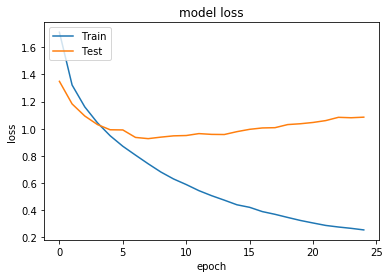

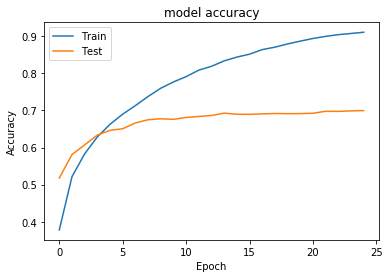

In [8]:
# evaluate model on test accuracy
scores = model.evaluate(X_test, y_test, verbose=0)
print "\nAccuracy: %.2f%%" % (scores[1]*100)

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Building a Deeper Model

Image classification on 3-channel (colored) images is a complex task, so model complexity needs to be improved significantly. Using the same pattern of conv, dropout, conv, max pool from the previous network, we are able to efficiently construct a much deeper network from before (now 19 layers instead of 8). We stick to this cycle of convolutions and pooling layers to gain as much information from previous layers as possible, and then "summarizing" it for the next layer. Adding dropout layers to deeper networks becomes increasingly more essential in computation time, which is why so many are included in this model.

Network architecture:
    1. Conv input with relu activation
    2. Dropout 20%
    3. Conv layer with relu activation
    4. Max Pool
    5. Conv layer with relu activation
    6. Dropout 20%
    7. Conv layer with relu activation
    8. Max Pool
    9. Conv layer with relu activation
    10. Dropout 20%
    11. Conv layer with relu activation
    12. Max Pool
    13. Flatten
    14. Dropout 20%
    15. Dense (F.C.) layer with 1024 units and relu activation
    16. Dropout 20%
    17. Dense (F.C.) layer with 512 units and relu activation
    18. Dropout 20%
    19. 10-unit softmax F.C. output layer
    
In order to compare results to the previous model, we retain the same number of epoch (25) and SGD for backpropagation. However, we also increase batch size to 64 to reduce computation time. If this is not successful, we will re-visit a batch size of 32.

In [14]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        36928     
__________

In [15]:
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 251us/step - loss: 1.9792 - acc: 0.2653 - val_loss: 1.6980 - val_acc: 0.3887
Epoch 2/25
50000/50000 [==============================] - 12s 236us/step - loss: 1.5390 - acc: 0.4376 - val_loss: 1.3821 - val_acc: 0.4882
Epoch 3/25
50000/50000 [==============================] - 11s 228us/step - loss: 1.3535 - acc: 0.5073 - val_loss: 1.2442 - val_acc: 0.5523
Epoch 4/25
50000/50000 [==============================] - 11s 227us/step - loss: 1.2177 - acc: 0.5627 - val_loss: 1.1571 - val_acc: 0.5802
Epoch 5/25
50000/50000 [==============================] - 11s 228us/step - loss: 1.1093 - acc: 0.6011 - val_loss: 1.0272 - val_acc: 0.6304
Epoch 6/25
50000/50000 [==============================] - 12s 237us/step - loss: 1.0146 - acc: 0.6394 - val_loss: 0.9537 - val_acc: 0.6605
Epoch 7/25
50000/50000 [==============================] - 12s 234us/step - loss: 0.9330 - acc: 0.6697 - val_loss: 0.

### Deeper Model Evaluation

Increasing batch size to 64, but still only training on 25 epoch, we attain test accuracy of 78.32% and see much more promising feedback from our loss and accuracy plots. An important piece to note in the "model loss" plot is that both training and test losses are still decreasing; this is an indication that we haven't yet over-fit the data, and there is still information to be gained from the data. Likewise, we can see the accuracies continuously improving with more epoch, indicating that we could be iterating over our dataset more than we currently are.

It is also interesting to note the training time per epoch on this 19-layer model as opposed to the previous 8-layer model. Dropout layers are obviously play an essential role in this aspect, but we can likely attribute the improved computation time to the increased batch size, as the number of iterations per epoch has decreased.

This marked the end of coding for the tutorial, but they offered a few suggestions that we will attempt in the following section.


Accuracy: 78.32%


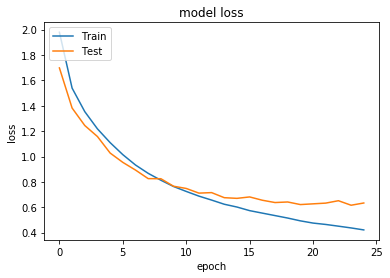

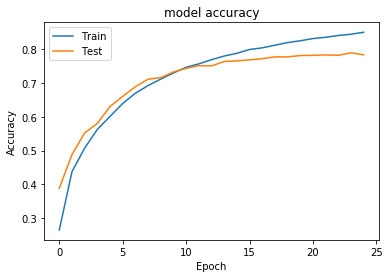

In [16]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print "\nAccuracy: %.2f%%" % (scores[1]*100)

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Model Improvement

Some suggestions to improve our model performance included (1) increasing the number of epochs, (2) attempting data augmentation, and (3) potentially creating a deeper network with less aggressive pooling or more feature maps closer to the input. One technique I would also like to attempt is transfer learning with a pre-trained model.

# Increased Epoch

A primary attempt at improving model performance is increasing epoch, essentially giving the model weights more time to converge to "ideal". Although this is not always the case, our prior results have suggested this as a possibility because of continual decrease in both training and cross-validation loss. We look to double the epoch to 50 to evaluate the effect of increased iterations, without spending too much computation time. If the results prove to be promising and test accuracy continues to increase after 50 epoch, we can bump this amount up even more.

In [9]:
# 1. Increase epoch

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# compile model and use adam optimizer instead of sgd
epochs = 50
#lrate = 0.01
#decay = lrate/epochs
#sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        36928     
__________

In [10]:
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.6116 - acc: 0.4039 - val_loss: 1.4345 - val_acc: 0.4760
Epoch 2/50
50000/50000 [==============================] - 11s 221us/step - loss: 1.1737 - acc: 0.5797 - val_loss: 1.0170 - val_acc: 0.6439
Epoch 3/50
50000/50000 [==============================] - 11s 221us/step - loss: 0.9698 - acc: 0.6557 - val_loss: 0.9143 - val_acc: 0.6781
Epoch 4/50
50000/50000 [==============================] - 11s 215us/step - loss: 0.8493 - acc: 0.6999 - val_loss: 0.8011 - val_acc: 0.7142
Epoch 5/50
50000/50000 [==============================] - 11s 215us/step - loss: 0.7582 - acc: 0.7315 - val_loss: 0.7442 - val_acc: 0.7419
Epoch 6/50
50000/50000 [==============================] - 11s 212us/step - loss: 0.6952 - acc: 0.7578 - val_loss: 0.7246 - val_acc: 0.7504
Epoch 7/50
50000/50000 [==============================] - 10s 208us/step - loss: 0.6455 - acc: 0.7708 - val_loss: 0.

### Increased Epoch Evalutation

Testing accuracy improved to just over 80% (2% increase from 25 epoch), indicating that the model improves with additional training time. However, when evaluating the loss and accuracy plots, it is fairly evident that cross-validation for each plateaus around 25-30 epoch; this is where we are "allowed" to stop training because the model will inherently not gain any additional information or accuracy after this point. Although this is good information to know for this model architecture, changing it could change where our model converges, so this will have to be something we keep an eye on in the future.


Accuracy: 80.08%


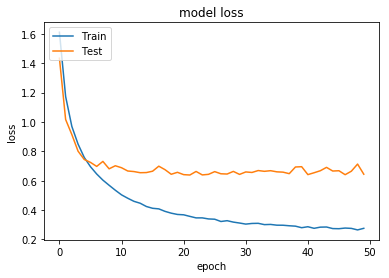

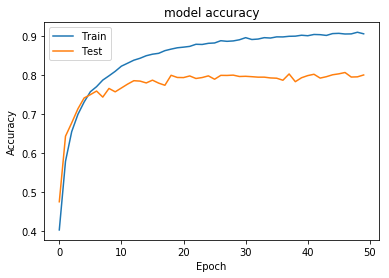

In [11]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print "\nAccuracy: %.2f%%" % (scores[1]*100)

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Data Augmentation

Again, implementing the same architecture, we attempt data augmentation. Data augmentation is a process of taking a single image, and basically duplicating it by various transformations to make it look like a "new" image to the model. The process as a whole can involve shearing, rotations, zooming, cropping, and changes to image lighting (RGB channels), or a combination of any or all of them. CNN's are extremely beneficial for recognizing patterns and shapes in images; thus, if we feed several of similar images into the algorithm in different instances, we are able to falsely create a multi-fold duplicate dataset. Because we saw the ideal epoch cutoff to be a little after 25, we now increase that to 30. Also, because we benefited from improved computation time without sacrificing accuracy, so we set the batch size to 64.

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        36928     
__________

In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.2,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.2,
    shear_range=0.2,  # set range for random shear
    zoom_range=0.2,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

datagen.fit(X_train)

batch_size = 64
epochs = 30

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    workers=4)

Epoch 1/30
782/782 [==============================] - 34s 43ms/step - loss: 1.9232 - acc: 0.2792 - val_loss: 1.5944 - val_acc: 0.4062
Epoch 2/30
782/782 [==============================] - 33s 42ms/step - loss: 1.6511 - acc: 0.3890 - val_loss: 1.3906 - val_acc: 0.4822
Epoch 3/30
782/782 [==============================] - 33s 42ms/step - loss: 1.5296 - acc: 0.4406 - val_loss: 1.2873 - val_acc: 0.5258
Epoch 4/30
782/782 [==============================] - 32s 41ms/step - loss: 1.4394 - acc: 0.4767 - val_loss: 1.1950 - val_acc: 0.5686
Epoch 5/30
782/782 [==============================] - 33s 42ms/step - loss: 1.3823 - acc: 0.5041 - val_loss: 1.1601 - val_acc: 0.5774
Epoch 6/30
782/782 [==============================] - 32s 41ms/step - loss: 1.3249 - acc: 0.5263 - val_loss: 1.1799 - val_acc: 0.5864
Epoch 7/30
782/782 [==============================] - 32s 40ms/step - loss: 1.2869 - acc: 0.5382 - val_loss: 1.0471 - val_acc: 0.6268
Epoch 8/30
782/782 [==============================] - 32s 41ms

### Data Augmentation Evaluation

Implementing 40 degree rotations, shifting up/down and left/right by 20%, shearing 20%, zooming 20%, and horizontally flipping images, we unfortunately find that we drop back to an accuracy of only 71.75%. Doing some additional research, I find common answers that data augmentation is typically performed on small datasets (< 1000 images). We have a set of 5,000 images to train on, so a potential drawback may be added complexity and computation time without acutally adding any additional information. The algorithm likely "sees" the same image several times, and thus learns nothing new because there are already a large variety of images to sort through. This is a good techinque to keep in the back pocket, although it was not successful in this case.


Accuracy: 71.75%


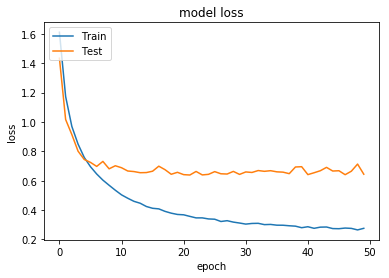

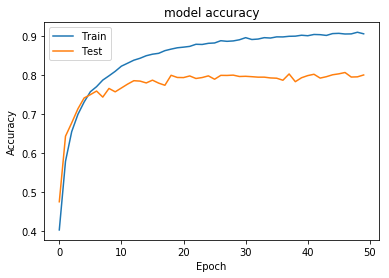

In [14]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print "\nAccuracy: %.2f%%" % (scores[1]*100)

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Transfer Learning

Transfer learning is a method where a model previously trained for a task is reused as the "starting point" for a model on a new task. By "freezing" weights of a previous model and only updating the last few output layers to fit the constraints of our problem, the model is able to implement the previously learned features on new images. VGG-16 network is a heavily-researched CNN that has been built to attain state-of-the-art results; the architecture is essentially several repetitions of 2-3 convolution layers, followed by pooling layers, and 3 F.C. layers at the end (for a total of 16). A major dataset this network has been implemented on is "imagenet", which is an extremely large database of 14 million images with labels; with the large dataset, progressing through the layers allows the model to identify several different lines and shapes near the beginning, and piece together a correclty identified image by the output layers. Because we are dealing with the CIFAR-10 dataset which contains images similar to those found in imagenet, transfer learning makes it easy to "steal" the information from the VGG-16 architecture with weights on this trained set, and simply replace the last F.C. layers with output of our own. As an initial try with transfer learning, we add a flatten layer, a dense F.C. layer with 16 output nodes and relu activation, dropout of 20%, and finally a 10-unit output layer. Keeping consistency from before, we train on 30 epoch and batch size of 64.

In [15]:
from keras import applications
from keras.models import Model

#Create transfer learning model
input_shape = X_train.shape[1:]

#load base_model
base_model = applications.VGG16(weights='imagenet',
                                include_top=False,
                                input_shape=input_shape)

top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(16, activation='relu'))
top_model.add(Dropout(0.2))
top_model.add(Dense(num_classes, activation='softmax'))

transfer_model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

for layer in transfer_model.layers[:19]:
    layer.trainable = False

transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [16]:
#Compile model
transfer_model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

#Fit the model
history = transfer_model.fit(x = X_train, y = y_train, validation_split=0.2, epochs = 30, batch_size = 64)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 10s 249us/step - loss: 0.2690 - acc: 0.9039 - val_loss: 0.2285 - val_acc: 0.9111
Epoch 2/30
40000/40000 [==============================] - 9s 229us/step - loss: 0.2359 - acc: 0.9106 - val_loss: 0.2138 - val_acc: 0.9162
Epoch 3/30
40000/40000 [==============================] - 9s 231us/step - loss: 0.2265 - acc: 0.9137 - val_loss: 0.2083 - val_acc: 0.9191
Epoch 4/30
40000/40000 [==============================] - 9s 236us/step - loss: 0.2219 - acc: 0.9154 - val_loss: 0.2029 - val_acc: 0.9211
Epoch 5/30
40000/40000 [==============================] - 9s 235us/step - loss: 0.2179 - acc: 0.9167 - val_loss: 0.2011 - val_acc: 0.9218
Epoch 6/30
40000/40000 [==============================] - 9s 232us/step - loss: 0.2148 - acc: 0.9178 - val_loss: 0.1973 - val_acc: 0.9238
Epoch 7/30
40000/40000 [==============================] - 9s 222us/step - loss: 0.2115 - acc: 0.9190 - val_loss: 0.1956 -

### Transfer Learning Evaluation

Implementing transfer learning via the VGG-16 architecture, we see the increase in parameters has increased from approximately 3 million to over 14 million; this in itself should be where a significant amount of accuracy comes in. However, since a majority of the weights from layers up until our F.C. layers have already been trained, our new model only needs to train on just over 8,000 parameters. We see this difference in the quick amount of time the model takes to train. In 30 epoch, we attain a test accuracy of 92.61%, which is over 12% higher than any other attempt at modeling than we previously attempted. Cross-validation loss tapers off around 25-30 epoch, indicating that we have likely hit our training limit. One important thing to note in these plots is the flip-flopped train/test accuracy/loss curves; from quick research, we can see that this is a trait of a well-trained model, in addition to dropout layers being included near the end of the architecture.

To test whether this is the best possible model we could create with transfer learning, we use the same F.C. output layers and attempt training for 50 epoch with a batch size of 32. We find that this results in test accuracy of 92.46%; this is not an improvment, and we see that accuracy and loss curves are similar but not as stable as the model with batch size 64. We can draw conclusions that having smaller batch size begins with greater loss and higher accuracy, and takes more epoch to converge to a solution. Testing this same model with an increased batch size of 128, we see that this is almost "ideal" for computing weights, and results in overfit data within the first 5 epoch; however, we see that test accuracy is still not improved, so we prefer to train the model slightly longer to ensure it hasn't overfit the data if we can keep the same accuracy.


Accuracy: 92.61%


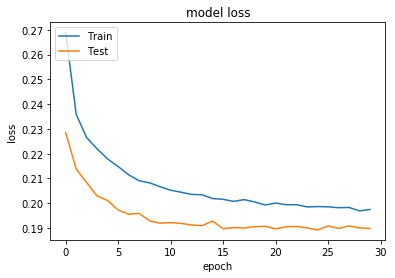

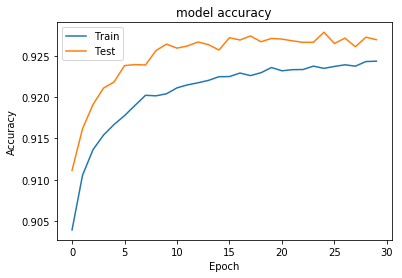

In [17]:
# Final evaluation of the model
scores = transfer_model.evaluate(X_test, y_test, verbose=0)
print "\nAccuracy: %.2f%%" % (scores[1]*100)

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()